# Task 2

### Integrantes
* Sergio Orellana 221122
* Rodrigo Mansilla 22611
* Ricardo Chuy 221007

El objetivo de esta parte es implementar el pipeline de alineación sin depender de cajas negras. Por ello considere que no deben de usar cv2.findHonography o cv2.RANSAC. Además para este laboratorio necesitara crear su propio dataset, por ello tome 3 fotografías propias de una escena planar (i.e. una pancarta en una pared, un cuadro, o una fachada de edificio lejana) con ángulos y perspectivas drásticamente diferentes.


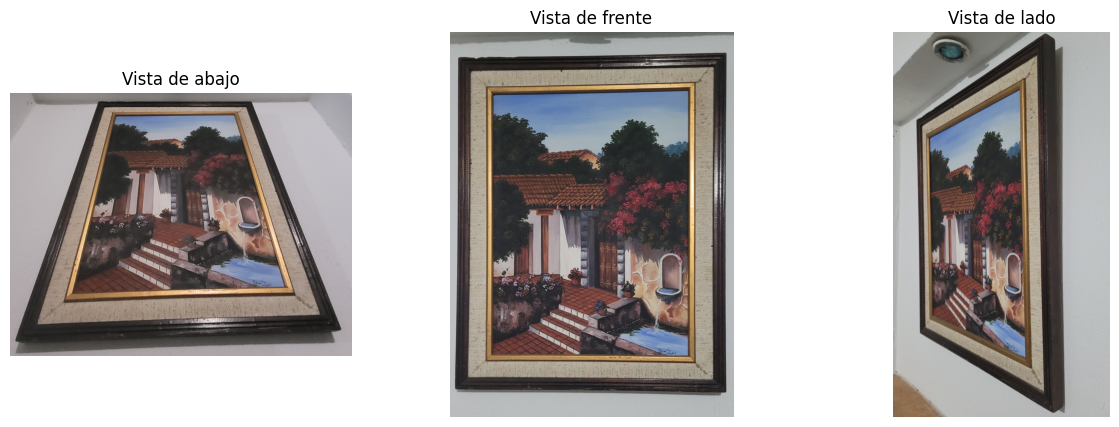

In [1]:
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

img1 = mpimg.imread('imgs/abajo.jpg')
img2 = mpimg.imread('imgs/frente.jpg')
img3 = mpimg.imread('imgs/lado.jpg')
# por algun motivo la imagegn 3 sale horizontalmente, entonces le di vuelta jej
img3 = np.rot90(img3, k=-1)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 fila, 3 columnas

axes[0].imshow(img1)
axes[0].set_title('Vista de abajo')
axes[0].axis('off')  

axes[1].imshow(img2)
axes[1].set_title('Vista de frente')
axes[1].axis('off')

axes[2].imshow(img3)
axes[2].set_title('Vista de lado')
axes[2].axis('off')

# plt.tight_layout()  # Ajustar espaciado
plt.show()

## 1. Detección y Macheo
* a. Utilice SIFT u ORB (permitido usar OpenCV aquí) para detectar puntos de interés y descriptores.
* b. Realice un emparejamiento de fuerza bruta (Brute-Force Matcher).
* c. Requisito: Visualice los matches antes de filtrar. Debe verse una cantidad considerable de ruido/errores

### Parte a

In [2]:

PATH_REF = 'imgs/frente.jpg'   
PATH_OBJ = 'imgs/abajo.jpg'     

print(f"Referencia: {PATH_REF}\n Objetivo:   {PATH_OBJ}")

# 
img_ref_bgr = cv2.imread(PATH_REF)
img_obj_bgr = cv2.imread(PATH_OBJ)

# Validación simple
if img_ref_bgr is None or img_obj_bgr is None:
    raise ValueError("No se encontro la img")

img_ref_rgb = cv2.cvtColor(img_ref_bgr, cv2.COLOR_BGR2RGB)
img_obj_rgb = cv2.cvtColor(img_obj_bgr, cv2.COLOR_BGR2RGB)

img_ref_gray = cv2.cvtColor(img_ref_bgr, cv2.COLOR_BGR2GRAY)
img_obj_gray = cv2.cvtColor(img_obj_bgr, cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()

# los keypoints y descriptores
kp_ref, des_ref = sift.detectAndCompute(img_ref_gray, None)
kp_obj, des_obj = sift.detectAndCompute(img_obj_gray, None)

print(f"Keypoints en Referencia: {len(kp_ref)}")
print(f"Keypoints en Objetivo:   {len(kp_obj)}")



Referencia: imgs/frente.jpg
 Objetivo:   imgs/abajo.jpg
Keypoints en Referencia: 28311
Keypoints en Objetivo:   10239


### Parte b

In [3]:
# Usamos Fuerza Bruta con distancia Euclidiana, el k=2 igual que en el lab pasado significa
# los 2 mejores matches
matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
matches_crudos = matcher.knnMatch(des_ref, des_obj, k=2)

print(f"Matches Totales: {len(matches_crudos)}")

Matches Totales: 28311


### Parte c

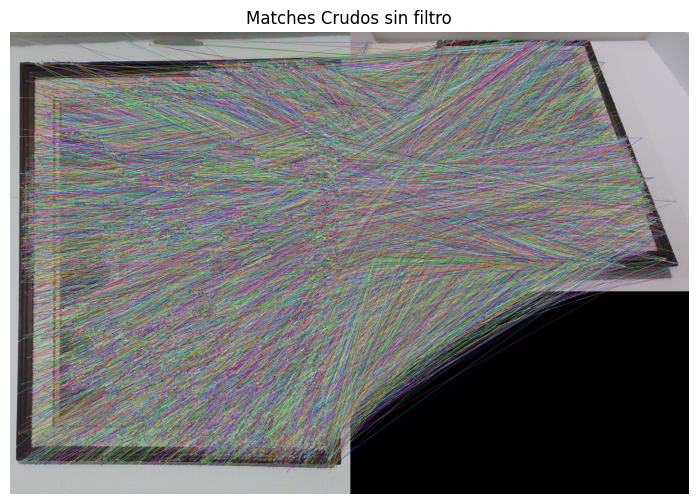

In [4]:
matches_sin_filtro = [m for m, n in matches_crudos]

img_ruido = cv2.drawMatches(
    img_ref_rgb, kp_ref, 
    img_obj_rgb, kp_obj, 
    matches_sin_filtro, # Pasamos la muestra ruidosa
    None, 
    flags=2
)

plt.figure(figsize=(15, 6))
plt.title("Matches Crudos sin filtro")
plt.imshow(img_ruido)
plt.axis('off')
plt.show()

Matches Totales: 28311
Matches Buenos: 1102


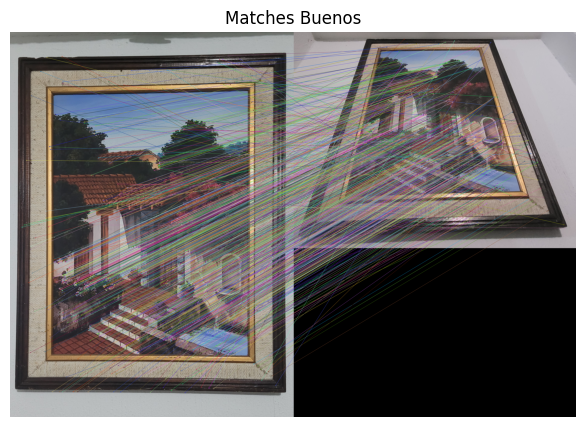

In [5]:
# esto es algo extra que quisimos poner para verificar el match con filtro como el lab pasado

ratio = 0.75
matches_buenos = []

for m, n in matches_crudos:
    if m.distance < ratio * n.distance:
        matches_buenos.append(m)

print(f"Matches Totales: {len(matches_crudos)}")
print(f"Matches Buenos: {len(matches_buenos)}")

# visualizacion de los matches
img_matches = cv2.drawMatches(img_ref_rgb, kp_ref, img_obj_rgb, kp_obj, matches_buenos, None, flags=2)
plt.figure(figsize=(15, 5))
plt.title("Matches Buenos")
plt.imshow(img_matches)
plt.axis('off')
plt.show()


## 2. Algoritmo DLT
a. Escriba una función calcular_homografia_dlt(puntos_src, puntos_dst) que
reciba exactamente 4 pares de puntos.

b. Debe construir la matriz A de tamaño 8×9.

c. Debe resolver el sistema usando SVD (numpy.linalg.svd).

d. Nota: Debe normalizar los puntos antes de entrar al DLT (restar la media y dividir por la desviación estándar) para estabilidad numérica, y des-normalizar la matriz H resultante.

### Función de Homografía

In [6]:
def normalizar_puntos(puntos, eps=1e-12):
    puntos = np.asarray(puntos, dtype=np.float64)
    if puntos.ndim != 2 or puntos.shape[1] != 2:
        raise ValueError("puntos debe tener forma (N,2)")

    mu = np.mean(puntos, axis=0)
    sigma = np.std(puntos, axis=0)
    sigma[sigma < eps] = 1.0  

    T = np.array([
        [1.0/sigma[0], 0.0, -mu[0]/sigma[0]],
        [0.0, 1.0/sigma[1], -mu[1]/sigma[1]],
        [0.0, 0.0, 1.0]
    ], dtype=np.float64)

    pts_h = np.hstack([puntos, np.ones((puntos.shape[0], 1))])
    pts_n = (T @ pts_h.T).T
    return pts_n[:, :2], T

def calcular_homografia_dlt(puntos_src, puntos_dst, eps=1e-12):
    """
    DLT con N>=4 pares de puntos (para refinamiento con inliers).
    Construye la matriz A de tamaño 2N×9 y resuelve con SVD.
    """
    src = np.asarray(puntos_src, dtype=np.float64)
    dst = np.asarray(puntos_dst, dtype=np.float64)
    
    if src.shape[0] < 4 or dst.shape[0] < 4:
        raise ValueError("Se requieren al menos 4 pares de puntos.")
    if src.shape[0] != dst.shape[0] or src.shape[1] != 2 or dst.shape[1] != 2:
        raise ValueError("src y dst deben tener forma (N,2) con el mismo N.")

    src_n, T_src = normalizar_puntos(src)
    dst_n, T_dst = normalizar_puntos(dst)

    # Matriz A de 2N×9
    A = []
    for (x, y), (xp, yp) in zip(src_n, dst_n):
        A.append([-x, -y, -1,  0,  0,  0, x*xp, y*xp, xp])
        A.append([ 0,  0,  0, -x, -y, -1, x*yp, y*yp, yp])

    A = np.asarray(A, dtype=np.float64)  # (2N, 9)
    _, _, Vt = np.linalg.svd(A)
    Hn = Vt[-1].reshape(3, 3)

    H = np.linalg.inv(T_dst) @ Hn @ T_src
    if abs(H[2, 2]) < eps:
        return H
    return H / H[2, 2]


### 3. RANSAC Manual
a. Implemente la función ransac_homografia(matches, umbral, prob_exito).

b. Cálculo de N: Su código debe calcular dinámicamente el número de iteraciones N basado
en la fórmula de probabilidad vista en clase. No "hardcodee" el número 1000.

c. Bucle:
    i. Seleccione 4 matches aleatorios.
    ii. Llame a su función DLT.
    iii. Proyecte todos los puntos fuente usando H_test.
    iv. Calcule el error de reproyección (distancia Euclidiana) y cuente los inliers.

a. Refinamiento: Una vez encontrado el mejor conjunto de inliers, recalcule 𝐻 final usando todos los inliers (no solo los 4 iniciales) mediante SVD


In [18]:
def ransac_homografia(matches, kp_src, kp_dst, umbral, prob_exito=0.99):
    """
    RANSAC manual para estimar homografía OBJ → REF.
    
    matches fueron creados con knnMatch(des_ref, des_obj),
    por lo que queryIdx → kp_ref y trainIdx → kp_obj.
    
    Para estimar H: OBJ → REF directamente, se usa:
      src_pts = puntos en OBJ (trainIdx)
      dst_pts = puntos en REF (queryIdx)
    """
    obj_pts = np.array([kp_dst[m.trainIdx].pt for m in matches])   
    ref_pts = np.array([kp_src[m.queryIdx].pt for m in matches])   
    num_matches = len(matches)

    s = 4               # puntos por muestra
    w = 0.5             # estimación inicial de ratio de inliers
    N = int(np.ceil(np.log(1 - prob_exito) / np.log(1 - w**s))) if w < 1 else 1

    mejor_H = None
    mejor_inliers = []
    iteracion = 0

    while iteracion < N:
        if num_matches < 4:
            break
        idx = np.random.choice(num_matches, size=4, replace=False)
        
        src_4 = obj_pts[idx]   
        dst_4 = ref_pts[idx]   

        try:
            H_test = calcular_homografia_dlt(src_4, dst_4)  # DLT con exactamente 4 pts (A=8×9)
        except:
            iteracion += 1
            continue

        pts_h = np.hstack([obj_pts, np.ones((num_matches, 1))])  
        proj_h = (H_test @ pts_h.T).T
        proj = proj_h[:, :2] / proj_h[:, 2:3]

        # distancia Euclidiana
        errores = np.linalg.norm(proj - ref_pts, axis=1)
        inliers = np.where(errores < umbral)[0]

        if len(inliers) > len(mejor_inliers):
            mejor_inliers = inliers
            mejor_H = H_test

            # Actualizar w y recalcular N dinámicamente
            w = len(inliers) / num_matches
            if w == 1:
                N = 1
            else:
                N = int(np.ceil(np.log(1 - prob_exito) / np.log(1 - w**s)))

        iteracion += 1

    # Refinamiento: recalcular H con TODOS los inliers
    if len(mejor_inliers) >= 4:
        H_final = calcular_homografia_dlt(
            obj_pts[mejor_inliers],
            ref_pts[mejor_inliers]
        )
    else:
        H_final = mejor_H

    print(f"Inliers: {len(mejor_inliers)} / {num_matches}")
    print(f"Iteraciones: {iteracion}")
    return H_final, mejor_inliers

#### Salida

Inliers: 607 / 1102
Iteraciones: 48
Homografía encontrada (OBJ → REF):
[[ 2.04047982e+00  7.26832280e-01 -1.16050748e+03]
 [-4.49415128e-02  3.75848691e+00  9.17677003e+00]
 [-4.76104383e-05  7.12518664e-04  1.00000000e+00]]

Canvas: 5019x3184
Recorte: [114:3019, 1205:3373]
Imagen recortada: 2168x2905


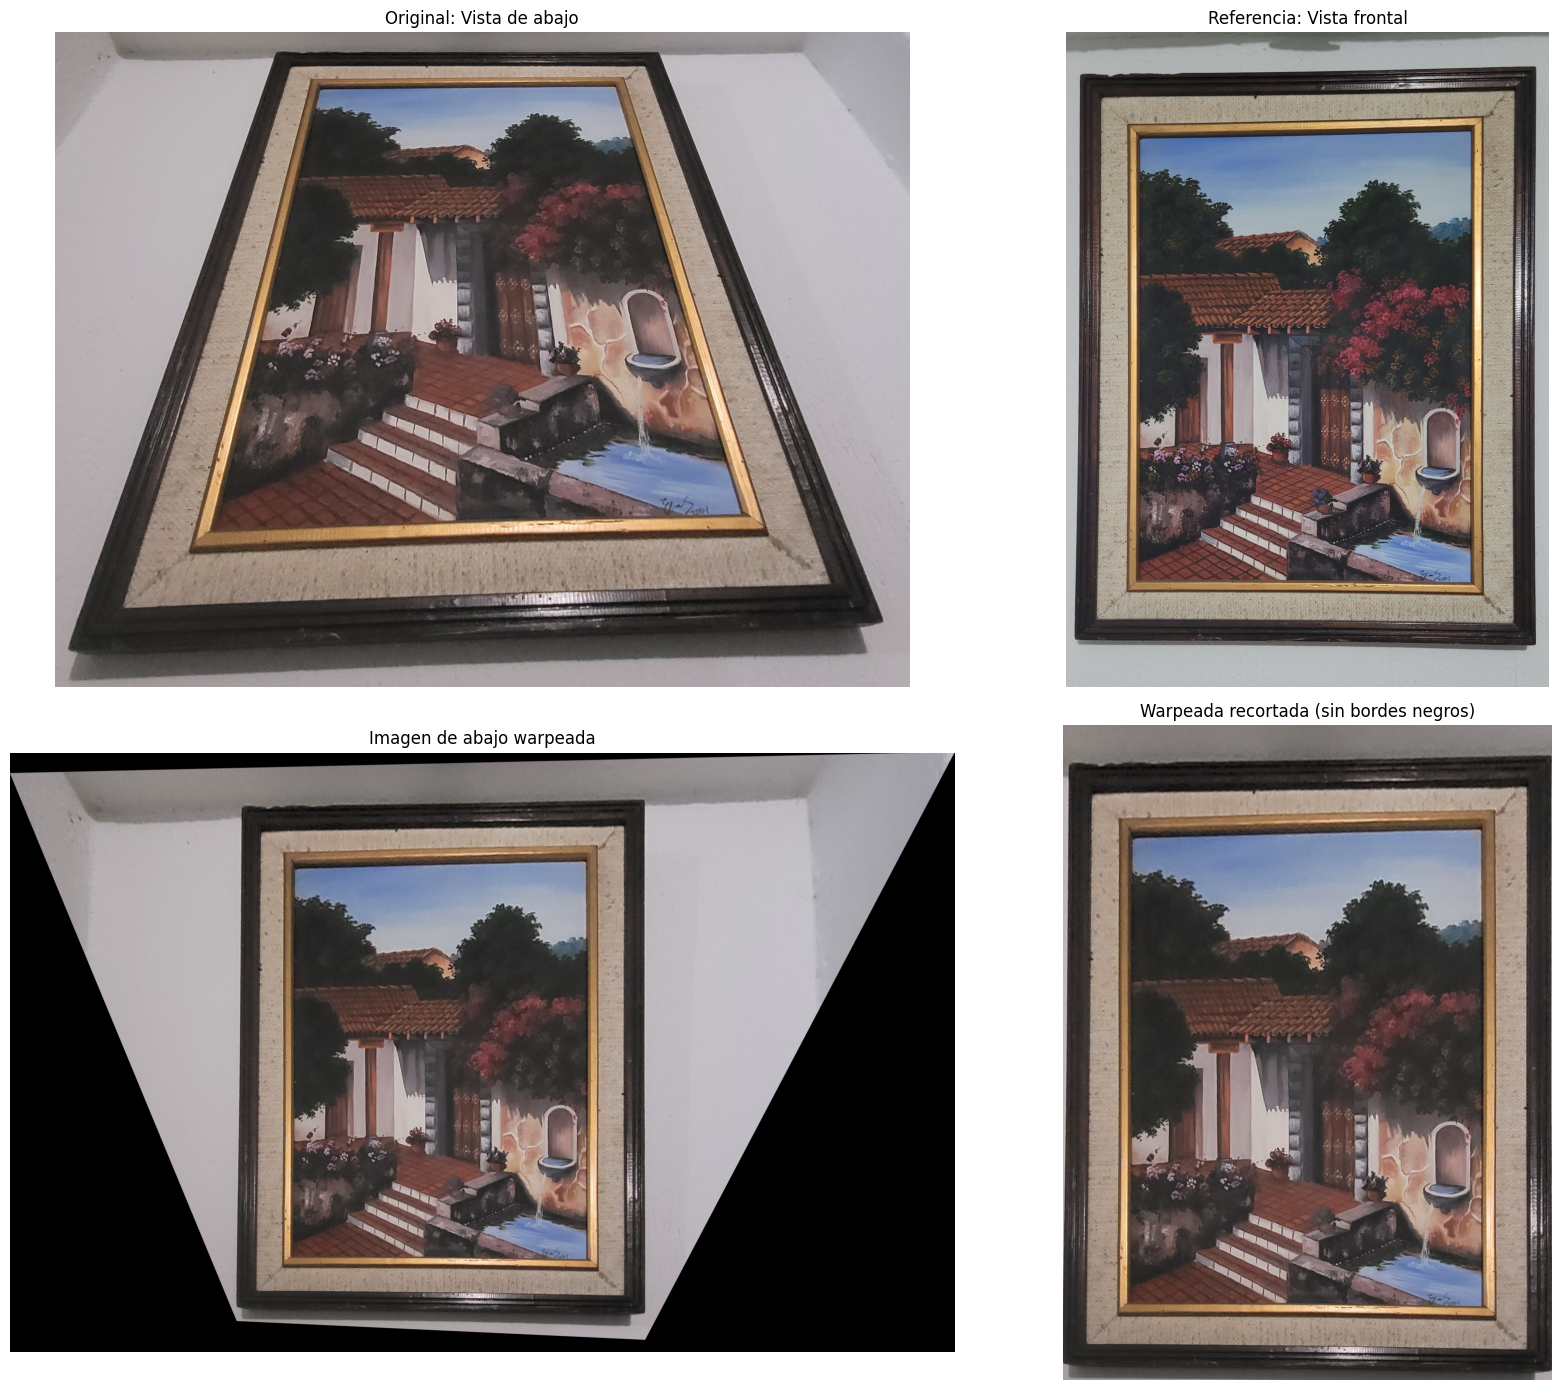

In [ ]:

H_final, inliers = ransac_homografia(
    matches_buenos, kp_ref, kp_obj, 
    umbral=5.0, prob_exito=0.99
)

print("Homografía encontrada (OBJ → REF):")
print(H_final)

h_ref, w_ref = img_ref_rgb.shape[:2]
h_obj, w_obj = img_obj_rgb.shape[:2]

# Proyectar las esquinas de OBJ al espacio de REF
esquinas_obj = np.array([[0,0],[w_obj,0],[w_obj,h_obj],[0,h_obj]], dtype=np.float64)
esquinas_h = np.hstack([esquinas_obj, np.ones((4, 1))])
esquinas_proj = (H_final @ esquinas_h.T).T
esquinas_proj = esquinas_proj[:, :2] / esquinas_proj[:, 2:3]

todas_esquinas = np.vstack([
    esquinas_proj, 
    [[0,0],[w_ref,0],[w_ref,h_ref],[0,h_ref]]
])

x_min = int(np.floor(todas_esquinas[:, 0].min()))
y_min = int(np.floor(todas_esquinas[:, 1].min()))
x_max = int(np.ceil(todas_esquinas[:, 0].max()))
y_max = int(np.ceil(todas_esquinas[:, 1].max()))

T_traslacion = np.array([[1,0,-x_min],[0,1,-y_min],[0,0,1]], dtype=np.float64)
ancho_canvas = x_max - x_min
alto_canvas = y_max - y_min

# Warp de la imagen OBJ
img_warp_obj = cv2.warpPerspective(
    img_obj_rgb, 
    T_traslacion @ H_final, 
    (ancho_canvas, alto_canvas)
)


esquinas_canvas = esquinas_proj.copy()
esquinas_canvas[:, 0] -= x_min  # aplicar traslación X
esquinas_canvas[:, 1] -= y_min  # aplicar traslación Y


crop_top    = int(np.ceil(max(esquinas_canvas[0, 1], esquinas_canvas[1, 1])))
crop_bottom = int(np.floor(min(esquinas_canvas[2, 1], esquinas_canvas[3, 1])))
crop_left   = int(np.ceil(max(esquinas_canvas[0, 0], esquinas_canvas[3, 0])))
crop_right  = int(np.floor(min(esquinas_canvas[1, 0], esquinas_canvas[2, 0])))

# Recortar
img_warp_cropped = img_warp_obj[crop_top:crop_bottom, crop_left:crop_right]

print(f"\nCanvas: {ancho_canvas}x{alto_canvas}")
print(f"Recorte: [{crop_top}:{crop_bottom}, {crop_left}:{crop_right}]")
print(f"Imagen recortada: {img_warp_cropped.shape[1]}x{img_warp_cropped.shape[0]}")

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes[0,0].imshow(img_obj_rgb);      axes[0,0].set_title("Original: Vista de abajo"); axes[0,0].axis('off')
axes[0,1].imshow(img_ref_rgb);      axes[0,1].set_title("Referencia: Vista frontal"); axes[0,1].axis('off')
axes[1,0].imshow(img_warp_obj);     axes[1,0].set_title("Imagen de abajo warpeada"); axes[1,0].axis('off')
axes[1,1].imshow(img_warp_cropped); axes[1,1].set_title("Warpeada recortada (sin bordes negros)"); axes[1,1].axis('off')
plt.tight_layout()
plt.show()

# Task 3

### Integrantes
* Sergio Orellana 221122
* Rodrigo Mansilla 22611
* Ricardo Chuy 221007

## 1. Evaluación del umbral de RANSAC

### a) Gráfica: Umbral vs Número de Inliers

C:\Users\rodri\AppData\Local\Temp\ipykernel_4144\1035500192.py:40: RuntimeWarning: divide by zero encountered in divide
  proj = proj_h[:, :2] / proj_h[:, 2:3]
C:\Users\rodri\AppData\Local\Temp\ipykernel_4144\1035500192.py:40: RuntimeWarning: invalid value encountered in divide
  proj = proj_h[:, :2] / proj_h[:, 2:3]


Inliers: 148 / 1102
Iteraciones: 14154
  Umbral:   0.5 px  →  Inliers: 148

Inliers: 349 / 1102
Iteraciones: 456
  Umbral:   1.0 px  →  Inliers: 349

Inliers: 544 / 1102
Iteraciones: 76
  Umbral:   2.0 px  →  Inliers: 544

Inliers: 667 / 1102
Iteraciones: 45
  Umbral:   3.0 px  →  Inliers: 667

Inliers: 671 / 1102
Iteraciones: 32
  Umbral:   5.0 px  →  Inliers: 671

Inliers: 773 / 1102
Iteraciones: 17
  Umbral:   8.0 px  →  Inliers: 773

Inliers: 842 / 1102
Iteraciones: 12
  Umbral:  10.0 px  →  Inliers: 842

Inliers: 853 / 1102
Iteraciones: 11
  Umbral:  15.0 px  →  Inliers: 853

Inliers: 854 / 1102
Iteraciones: 11
  Umbral:  20.0 px  →  Inliers: 854

Inliers: 863 / 1102
Iteraciones: 10
  Umbral:  30.0 px  →  Inliers: 863

Inliers: 867 / 1102
Iteraciones: 10
  Umbral:  50.0 px  →  Inliers: 867



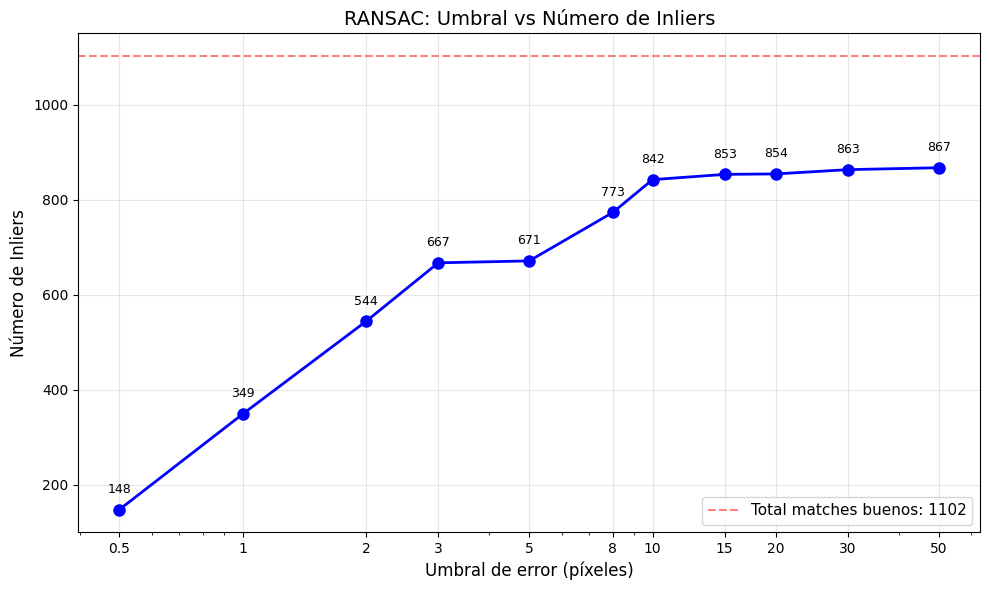

In [9]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

img_ref_bgr = cv2.imread('imgs/frente.jpg')
img_obj_bgr = cv2.imread('imgs/abajo.jpg')

img_ref_rgb = cv2.cvtColor(img_ref_bgr, cv2.COLOR_BGR2RGB)
img_obj_rgb = cv2.cvtColor(img_obj_bgr, cv2.COLOR_BGR2RGB)

img_ref_gray = cv2.cvtColor(img_ref_bgr, cv2.COLOR_BGR2GRAY)
img_obj_gray = cv2.cvtColor(img_obj_bgr, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()
kp_ref, des_ref = sift.detectAndCompute(img_ref_gray, None)
kp_obj, des_obj = sift.detectAndCompute(img_obj_gray, None)

matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
matches_crudos = matcher.knnMatch(des_ref, des_obj, k=2)

ratio = 0.75
matches_buenos = [m for m, n in matches_crudos if m.distance < ratio * n.distance]

umbrales = [0.5, 1, 2, 3, 5, 8, 10, 15, 20, 30, 50]
num_inliers_list = []
num_iteraciones_list = []

np.random.seed(42)  

for umbral in umbrales:
    H, inliers = ransac_homografia(
        matches_buenos, kp_ref, kp_obj,
        umbral=umbral, prob_exito=0.99
    )
    num_inliers_list.append(len(inliers))
    print(f"  Umbral: {umbral:5.1f} px  →  Inliers: {len(inliers)}")
    print()

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(umbrales, num_inliers_list, 'bo-', linewidth=2, markersize=8)

for u, n in zip(umbrales, num_inliers_list):
    ax.annotate(f'{n}', (u, n), textcoords="offset points", 
                xytext=(0, 12), ha='center', fontsize=9)

ax.set_xlabel('Umbral de error (píxeles)', fontsize=12)
ax.set_ylabel('Número de Inliers', fontsize=12)
ax.set_title('RANSAC: Umbral vs Número de Inliers', fontsize=14)
ax.set_xscale('log')
ax.set_xticks(umbrales)
ax.set_xticklabels([str(u) for u in umbrales])
ax.grid(True, alpha=0.3)

ax.axhline(y=len(matches_buenos), color='r', linestyle='--', alpha=0.5, 
           label=f'Total matches buenos: {len(matches_buenos)}')
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()


### b) Discusión: Riesgos del umbral

**Umbral demasiado estricto (ej. 0.5px):**

 Los detectores no son perfectos y la grán mayoría de los sensores tienen un ruido inherente que varía la posición del keypoint. Si este umbral es menor a la desviación estandar de el ruido, se rechazan inliers legítimo, evidenciado en la gráfica, siendo el punto más bajo el umbral más estricto. 

Matemáticamente,  según Según la fórmula de RANSAC, si el ratio de inliers (w) disminuye, la probabilidad de éxito cae a menos que aumentes las iteraciones (N) al infinito. Es decir nunca se puiede encontrar una solución, o no representa a toda la imagen.

**Umbral demasiado laxo (ej. 50px):**

En contraste, al ampliar el umbral, outliers entran a ser inliers. Al usar SVD, os mínimos cuadrados son extremadamente sensibles a valores atípicos, por lo que deforman H. Añadido a esto , se puede llegar la estructura geométrica. 

---

## 2. Caso práctico: Drones e imágenes térmicas de paneles solares

### a) Contexto del problema
El drone vuela a 50 metros de altura. El terreno no es perfectamente plano (hay colinas suaves), pero los paneles sí son planos.

### b) Pregunta A: ¿Es válido usar una Homografía global para unir todo el mapa del terreno?

La transoformación proyectiva puede realizarse si y solo si cumple una de las dos condiciones:
- La escena es perfectamente plana
- La camara solo rota sobre su propio eje, sin traslación.

El movimiento del drone representa traslación, y existen colinas, las cuales representan variaciones en profundidad. Esto introduce paralaje, cuando se desplaza los objetos a diferentes distancias se mueven a velocidades que pueden parecer distintas a pesar de ser los paneles planos. Por lo que crearia desalineaciones en zonas no planas del mapa.

### c) Pregunta B: Estrategia para reducir tiempo de RANSAC

**Contexto:** RANSAC tarda 3 segundos por frame en Raspberry Pi. El 90% de los matches iniciales son outliers debido al pasto y árboles repetitivos.

El tiempo de ejecución en RANSAC depende de las iteraciones en la fórmula:

$$ N = \frac{\ln(1-p)}{\ln(1-w^s)}$$

En donde w es el inlier ratio. 

90% son malos, lo que representa un $w=0.1$. Como para una Homografía necesitas s=4 puntos, el denominador es $(1−0.1^4)=0.9999$. Esto hace que N sea un número astronómico para garantizar el éxito $(p)$. 

Se propone un pre-filtrado en contraste con un mayor computo. Este pre-filtrado se busca que la RasPi trabaje menos. Se aumenta $w$ artificialmente antes de que los puntos lleguen a nuestro algoritmo RANSAC.

Adicionalmente se implementa un Lowe´s ratio , midiendo la distancia del mejor match con el segundo mejor, si estas son parecidas se descartan ambos. Con esto patrones repetitivos se eliminan, siendo estos posiblemente miles. 

Para evitar descartar los paneles, se ejecuta el RANSAC para las superficies planas que representan los planos, una vez filtrados los patrones repetitivos como arboles.



### Referencias

- Szeliski, R. (2022). Computer vision: Algorithms and applications (2.ª ed.). Springer. https://szeliski.org/Book/ 

- Hartley, R., & Zisserman, A. (2003). Multiple view geometry in computer vision (2da ed.). Cambridge University Press.

- Zhang, A., Lipton, Z. C., Li, M., & Smola, A. J. (2023). Dive into deep learning. Cambridge University Press. https://d2l.ai/

- Lowe, David G. “Distinctive Image Features from Scale-Invariant Keypoints.” International Journal of Computer Vision, vol. 60, no. 2, Nov. 2004, pp. 91–110, https://doi.org/10.1023/b:visi.0000029664.99615.94.

